# Methodology version 2!

A methodology that explores to design ortfolios based on identifying non-linear relationships between stocks


In [12]:
import copy
import datetime

import pandas as pd
import numpy as np
 
import src.utils.returns_preprocessing as preproc
import src.pca.eigen_portfolios_functions as eg_functions

import src.autoencoders.autoencoder_market_projection as ae_market
import src.autoencoders.autoencoder_portfolio_calibration as ae_portfolio_cal

import src.utils.portfolio_utils as portfolio_utils
import src.utils.returns_preprocessing as returns_preprocessing
import src.pca.rmf_filtering as rmf_filter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading the data

in this stage, I must collect other actions!!

In [13]:
# Load data

# stock componenet data
from collections import defaultdict
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('../Deep-Portfolio-Theory-master/data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('../Deep-Portfolio-Theory-master/data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('../Deep-Portfolio-Theory-master/data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('../Deep-Portfolio-Theory-master/data/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

In [14]:
stock['calibrate']['percentage']

,CELG US Equity,GILD US Equity,BIIB US Equity,AMGN US Equity,REGN US Equity,INCY US Equity,ILMN US Equity,MYL US Equity,VRTX US Equity,ALXN US Equity,...,AVDL US Equity,ARNA US Equity,GERN US Equity,NVAX US Equity,PDLI US Equity,SGMO US Equity,ZGNX US Equity,CGEN US Equity,MNOV US Equity,ARWR US Equity
1/6/2012,-0.5621,4.5199,4.9523,0.8566,18.690201,8.5943,4.2323,0.0466,2.5294,4.1259,...,9.4050,-13.3690,12.8378,8.7302,-1.1290,6.690100,27.0270,2.8283,6.4706,26.2530
1/13/2012,8.0482,4.9322,0.4589,4.3854,19.957399,3.4969,12.4016,1.1178,8.1057,0.2283,...,1.0526,1.8519,1.1976,-4.3796,-0.3263,7.920800,-8.8652,7.2692,2.2099,-0.5671
1/20/2012,1.6660,5.6806,1.8185,2.9142,-0.747600,2.4303,1.6522,-0.6909,-1.3583,-1.3937,...,-4.1667,-1.8182,2.3669,0.0000,3.6007,-2.140700,-3.1128,-2.5641,0.0000,2.4715
1/27/2012,-0.6365,2.6981,0.3555,-1.7680,9.204600,3.7037,42.3829,-2.4119,-0.9088,2.4735,...,10.1449,-1.8519,13.2948,10.6870,1.1058,3.125000,7.6305,2.8195,-2.7027,-9.4434
2/3/2012,-0.2181,12.2640,2.8003,1.3755,13.233600,-1.4509,0.2999,6.6540,2.2235,4.6088,...,8.0592,17.6101,5.8673,2.7586,1.2500,37.878799,1.8657,7.6782,25.0000,3.4624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/29/2013,-0.9551,0.7271,1.8745,0.9290,0.061300,-3.9571,-1.8331,3.4216,4.7375,1.3926,...,0.9611,11.4530,1.8975,7.2046,4.2133,8.148800,12.1528,2.7695,3.1532,10.6183
12/6/2013,2.8806,-1.0961,-0.0241,0.0351,-3.784100,-0.0215,1.2755,0.0227,-4.2783,0.7631,...,2.9990,-8.7423,9.1248,13.7097,-15.1484,2.129400,0.6192,-7.7960,-1.3100,-0.8505
12/13/2013,-0.9193,-3.5005,-5.3558,-1.7175,-4.650900,4.9367,3.2040,-5.3466,-1.9112,-1.4029,...,-1.1905,-6.5546,-18.6007,-8.5106,-2.7744,-2.245400,-7.0769,-9.1858,3.9823,-0.7353
12/20/2013,1.5646,4.5658,2.9130,1.6673,3.375500,5.0112,2.4309,1.7472,10.2025,5.6189,...,1.0710,0.1799,1.3627,27.3902,3.1017,12.715300,2.1523,-5.5172,-8.5106,22.5926


In [15]:
returns_preprocessing.log_returns(stock['calibrate']['lp'])

,CELG US Equity,GILD US Equity,BIIB US Equity,AMGN US Equity,REGN US Equity,INCY US Equity,ILMN US Equity,MYL US Equity,VRTX US Equity,ALXN US Equity,...,AVDL US Equity,ARNA US Equity,GERN US Equity,NVAX US Equity,PDLI US Equity,SGMO US Equity,ZGNX US Equity,CGEN US Equity,MNOV US Equity,ARWR US Equity
1/6/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/13/2012,0.077407,0.048144,0.004578,0.042920,0.181967,0.034372,0.116908,0.011116,0.077940,0.002281,...,0.010471,0.018349,0.011905,-0.044784,-0.003268,0.076227,-0.092831,0.070171,0.021859,-0.005687
1/20/2012,0.016522,0.055251,0.018022,0.028726,-0.007504,0.024013,0.016387,-0.006933,-0.013676,-0.014035,...,-0.042560,-0.018349,0.023393,0.000000,0.035373,-0.021639,-0.031623,-0.025975,0.000000,0.024414
1/27/2012,-0.006385,0.026624,0.003549,-0.017838,0.088053,0.036368,0.353350,-0.024414,-0.009130,0.024434,...,0.096627,-0.018692,0.124823,0.101536,0.010998,0.030772,0.073534,0.027805,-0.027399,-0.099195
2/3/2012,-0.002183,0.115683,0.027618,0.013661,0.124282,-0.014615,0.002995,0.064420,0.021991,0.045057,...,0.077509,0.162204,0.057017,0.027213,0.012423,0.321205,0.018485,0.073977,0.223144,0.034038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/29/2013,-0.009597,0.007245,0.018572,0.009246,0.000613,-0.040376,-0.018501,0.033644,0.046287,0.013830,...,0.009569,0.108433,0.018798,0.069569,0.041270,0.078338,0.114692,0.027319,0.031045,0.100915
12/6/2013,0.028399,-0.011022,-0.000241,0.000350,-0.038576,-0.000215,0.012674,0.000226,-0.043725,0.007602,...,0.029546,-0.091483,0.087322,0.128478,-0.164266,0.021070,0.006173,-0.081166,-0.013187,-0.008542
12/13/2013,-0.009236,-0.035632,-0.055045,-0.017324,-0.047626,0.048187,0.031538,-0.054949,-0.019297,-0.014129,...,-0.011976,-0.067793,-0.205803,-0.088948,-0.028136,-0.022710,-0.073398,-0.096355,0.039050,-0.007380
12/20/2013,0.015525,0.044647,0.028713,0.016535,0.033198,0.048897,0.024019,0.017321,0.097150,0.054667,...,0.010653,0.001797,0.013535,0.242085,0.030546,0.119695,0.021295,-0.056753,-0.088947,0.203696


In [16]:
returns_preprocessing.log_to_normal_returns(returns_preprocessing.log_returns(stock['calibrate']['lp']))

,CELG US Equity,GILD US Equity,BIIB US Equity,AMGN US Equity,REGN US Equity,INCY US Equity,ILMN US Equity,MYL US Equity,VRTX US Equity,ALXN US Equity,...,AVDL US Equity,ARNA US Equity,GERN US Equity,NVAX US Equity,PDLI US Equity,SGMO US Equity,ZGNX US Equity,CGEN US Equity,MNOV US Equity,ARWR US Equity
1/6/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/13/2012,0.080482,0.049322,0.004589,0.043854,0.199575,0.034969,0.124016,0.011178,0.081057,0.002283,...,0.010526,0.018519,0.011976,-0.043796,-0.003263,0.079208,-0.088652,0.072691,0.022099,-0.005671
1/20/2012,0.016660,0.056806,0.018185,0.029142,-0.007476,0.024303,0.016522,-0.006909,-0.013583,-0.013937,...,-0.041667,-0.018182,0.023669,0.000000,0.036006,-0.021407,-0.031128,-0.025641,0.000000,0.024715
1/27/2012,-0.006365,0.026981,0.003555,-0.017680,0.092046,0.037037,0.423829,-0.024119,-0.009088,0.024735,...,0.101449,-0.018518,0.132948,0.106870,0.011059,0.031250,0.076305,0.028196,-0.027027,-0.094434
2/3/2012,-0.002181,0.122640,0.028003,0.013755,0.132335,-0.014509,0.002999,0.066540,0.022235,0.046087,...,0.080592,0.176101,0.058674,0.027586,0.012500,0.378788,0.018657,0.076782,0.250000,0.034624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/29/2013,-0.009551,0.007271,0.018745,0.009289,0.000613,-0.039571,-0.018331,0.034216,0.047375,0.013926,...,0.009615,0.114530,0.018975,0.072046,0.042133,0.081488,0.121528,0.027696,0.031531,0.106183
12/6/2013,0.028807,-0.010961,-0.000241,0.000350,-0.037841,-0.000215,0.012755,0.000226,-0.042783,0.007631,...,0.029987,-0.087423,0.091248,0.137097,-0.151484,0.021294,0.006192,-0.077960,-0.013100,-0.008505
12/13/2013,-0.009193,-0.035005,-0.053558,-0.017175,-0.046509,0.049367,0.032040,-0.053466,-0.019112,-0.014029,...,-0.011905,-0.065546,-0.186007,-0.085106,-0.027744,-0.022454,-0.070769,-0.091858,0.039823,-0.007353
12/20/2013,0.015646,0.045658,0.029129,0.016673,0.033755,0.050112,0.024310,0.017472,0.102026,0.056189,...,0.010709,0.001799,0.013627,0.273902,0.031018,0.127153,0.021523,-0.055172,-0.085106,0.225926


In [17]:
ibb['calibrate']['percentage']/100

Date
6/1/2012      0.000000
13/1/2012     0.047943
20/1/2012     0.005785
27/1/2012     0.028850
3/2/2012      0.037674
                ...   
29/11/2013    0.016000
6/12/2013    -0.009591
13/12/2013   -0.029368
20/12/2013    0.038099
27/12/2013    0.009924
Name: % Change, Length: 104, dtype: float32

# Experiment


1. Execute the market modeling step to somehow differenciate the stocks different from the market!
2. Calculate linear risk factors using PCA from the most communal stocks
    2.1 PCA
    2.2 RMF (FIX THIS)
3. For each significant identified factor (including the one associated with the market), ammend its returns as an arbritary form to explore for arbritage opportunities
    3.1 mode one: Same as the article, arbritage opportunities in shocks! (negative correlation)
    3.2 mode two: diluted returns! a modification from the original article
4. Apply calibration step  for the factors! and see if such factors are beaten somehow!
    4.1 we might coin this new findings to a new non-linear factor capable of surpass in both modes 

### Stages methods!

In [18]:
# other methods
def plot_linear_factors(factors):
    for k,v in factors.items():
        portfolio_utils.plot_portfolio_performance(
            v['cumulative_returns'], 
            v['weights'], 
            df_train_index_stocks.columns, 
            'Portfolio with eVal {}'.format(v['eigen_value']))

In [25]:
## experiment methods
# PCA
def get_linear_factors(train, denoise = False, plot_optimization = False):
    D, S, eigen_portfolios = eg_functions.get_eigenvalues_and_eigenvectors(train, is_cov = False)
    portfolios_cache = {}
    i = 0
    for eig_portfolio in eigen_portfolios:
        cumulative_returns = portfolio_utils.get_portfolio_performance(train, eig_portfolio['weights'])
        portfolios_cache[i] = {'weights':eig_portfolio['weights'] , 
                               'eigen_value': eig_portfolio['eigen_value'],
                               'cumulative_returns': cumulative_returns}
        i += 1
    return portfolios_cache



def non_linear_factors_mapping(train):
    # fit market representation
    encoder_params = {'encoding_dim': 5,
                      'optimizer':'sgd', 
                      'loss':'mean_squared_error',
                      'l2_penalty': 0.01, 
                      'epochs': 1000, 
                      'batch_size': 100, 
                      'shuffle' : False,
                      'scale_data': False,
                      'hidden_layers_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence 
                      'output_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence -> after many tests, tanh is the best  
                      'batch_normalization': False}
    model = ae_market.autoencoder_market_projection_fit(train, encoder_params)
    # calculating most communal assets
    communal_assets = ae_market.communal_information(train, model) # test or train??
    #results
    return model, communal_assets


def selecting_tickers(df_returns, communal_assets, n_top = 15, n_bottom = 20):
    index_associated_stocks = communal_assets.head(n_top)['ticker']
    arbritage_stocks = communal_assets.tail(n_bottom)['ticker']
    return df_returns[index_associated_stocks], df_returns[arbritage_stocks]


def non_linear_factors_calibration(train, y_train,  rate_target = 0.05, ammend_shocks = False):
    y_amended = y_train.copy()
    y_amended[y_amended < -5] = 5
    y_amended[0] = 0
    encoder_params = {'encoding_dim': int(train.shape[1]*0.75),
                      'optimizer':'sgd', 
                      'loss':'mean_squared_error',
                      'l2_penalty': 0.01, 
                      'epochs': 500, 
                      'batch_size': 100, 
                      'shuffle' : False,
                      'scale_data': True,
                      'hidden_layers_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence 
                      'output_activation': 'softmax',
                      'batch_normalization': True,
                     'custom_loss_function' : ae_portfolio_cal.custom_matmult_rmse_loss}
    model = ae_portfolio_cal.autoencoder_portfolio_calibration_fit(train, y_amended, encoder_params)
    # predict
    portfolio_returns_train_hat, weights = ae_portfolio_cal.portfolio_returns_predict(train, model)
    return model, {'portfolio_returns_pred':portfolio_returns_train_hat,
                   'y_train': y_train,
                   'y_ammended': y_amended,
                  'weights': weights}
    

In [20]:
# implement cross-validation by 

In [28]:
train

,TLGT US Equity,INO US Equity,LXRX US Equity,NVAX US Equity,ZGNX US Equity,CERS US Equity,MNOV US Equity,CRIS US Equity,PDLI US Equity,IMMU US Equity,...,SHPG US Equity,UTHR US Equity,CELG US Equity,SRPT US Equity,ALXN US Equity,GILD US Equity,CLVS US Equity,VRTX US Equity,BIIB US Equity,REGN US Equity
1/6/2012,-3.4783,1.942200,-6.9767,8.7302,27.0270,0.7143,6.4706,-6.1966,-1.1290,1.2012,...,-4.6583,2.687800,-0.5621,10.201300,4.1259,4.5199,3.051800,2.5294,4.9523,18.690201
1/13/2012,-0.9009,-1.446800,21.6667,-4.3796,-8.8652,6.0284,2.2099,2.9613,-0.3263,2.3739,...,0.4644,-3.112100,8.0482,14.494500,0.2283,4.9322,0.137700,8.1057,0.4589,19.957399
1/20/2012,0.9091,-0.029100,-6.1644,0.0000,-3.1128,-6.6890,0.0000,4.8673,3.6007,1.4493,...,-2.1805,4.786200,1.6660,-12.766000,-1.3937,5.6806,36.863800,-1.3583,1.8185,-0.747600
1/27/2012,-0.9009,39.270100,14.5985,10.6870,7.6305,3.2258,-2.7027,9.2827,1.1058,-0.8571,...,2.8968,-0.629300,-0.6365,12.195100,2.4735,2.6981,-1.507500,-0.9088,0.3555,9.204600
2/3/2012,0.0000,12.746600,6.3694,2.7586,1.8657,9.7222,25.0000,-3.2819,1.2500,10.6628,...,-0.4692,2.574100,-0.2181,8.695700,4.6088,12.2640,21.479601,2.2235,2.8003,13.233600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/29/2013,14.6341,-1.869200,3.8961,7.2046,12.1528,2.7650,3.1532,13.4752,4.2133,-2.9213,...,-2.0130,-1.103500,-0.9551,19.257799,1.3926,0.7271,3.199200,4.7375,1.8745,0.061300
12/6/2013,-4.2553,-5.714300,-16.6667,13.7097,0.6192,-6.5770,-1.3100,7.1875,-15.1484,4.6296,...,-1.1781,-1.451600,2.8806,-3.057900,0.7631,-1.0961,-8.424400,-4.2783,-0.0241,-3.784100
12/13/2013,-8.5714,0.000000,-12.0000,-8.5106,-7.0769,-8.8000,3.9823,-25.9475,-2.7744,-12.8319,...,-0.8345,-3.056000,-0.9193,9.186500,-1.4029,-3.5005,-4.600600,-1.9112,-5.3558,-4.650900
12/20/2013,1.3889,8.585900,2.2727,27.3902,2.1523,7.3684,-8.5106,11.0236,3.1017,8.6294,...,3.4713,-0.396900,1.5646,-0.912300,5.6189,4.5658,7.024900,10.2025,2.9130,3.375500


### Orchestrator! .....

In [26]:
# test experiment
# split in train and test

# out params
#base = datetime.datetime.strptime('2013-03-01','%Y-%m-%d')
#date_iterations = [(base + datetime.timedelta(days = (30*x))).strftime('%Y-%m-%d') for x in range(10)]
#grid_rate_targets = np.linspace(0.01, 0.05, num = 5)

# inner loop params
test_period = 30
train_history = 150
date = '2022-11-01'
risk_free_rate = 0.04
index_ticker ='^BVSP'

"""
df_returns = preproc.get_normal_returns_from_prices(df_prices)

df_returns_without_index = df_returns.drop(index_ticker, axis = 1)
df_returns_train, df_returns_test = preproc.splitting_dataset_by_window(df_returns_without_index, date, train_history, test_period)
"""

#def train_orchestrator():
# 1. market modeling factors -- Tune network parameters -> tanh is the best activation layer, other experiments with other activation fucntions were done, but were not 

#model, communal_assets = non_linear_factors_mapping(stock['calibrate']['net'])

#indexes = communal_assets.head(10)['ticker'].append(communal_assets.tail(15)['ticker']).values
train = stock['calibrate']['percentage'][indexes]
portfolio_model, results = non_linear_factors_calibration(train, ibb['calibrate']['percentage'], rate_target = 0.05, ammend_shocks = False)
#


Epoch 1/500
2/2 [==============================] - 0s 14ms/step - loss: 3.0533
Epoch 2/500
2/2 [==============================] - 0s 14ms/step - loss: 3.0520
Epoch 3/500
2/2 [==============================] - 0s 15ms/step - loss: 3.0507
Epoch 4/500
2/2 [==============================] - 0s 15ms/step - loss: 3.0494
Epoch 5/500
2/2 [==============================] - 0s 16ms/step - loss: 3.0481
Epoch 6/500
2/2 [==============================] - 0s 15ms/step - loss: 3.0468
Epoch 7/500
2/2 [==============================] - 0s 16ms/step - loss: 3.0455
Epoch 8/500
2/2 [==============================] - 0s 16ms/step - loss: 3.0442
Epoch 9/500
2/2 [==============================] - 0s 16ms/step - loss: 3.0430
Epoch 10/500
2/2 [==============================] - 0s 22ms/step - loss: 3.0417
Epoch 11/500
2/2 [==============================] - 0s 21ms/step - loss: 3.0404
Epoch 12/500
2/2 [==============================] - 0s 16ms/step - loss: 3.0392
Epoch 13/500
2/2 [==============================]

2/2 [==============================] - 0s 15ms/step - loss: 2.9337
Epoch 104/500
2/2 [==============================] - 0s 15ms/step - loss: 2.9327
Epoch 105/500
2/2 [==============================] - 0s 15ms/step - loss: 2.9316
Epoch 106/500
2/2 [==============================] - 0s 14ms/step - loss: 2.9305
Epoch 107/500
2/2 [==============================] - 0s 15ms/step - loss: 2.9294
Epoch 108/500
2/2 [==============================] - 0s 17ms/step - loss: 2.9283
Epoch 109/500
2/2 [==============================] - 0s 18ms/step - loss: 2.9272
Epoch 110/500
2/2 [==============================] - 0s 20ms/step - loss: 2.9261
Epoch 111/500
2/2 [==============================] - 0s 21ms/step - loss: 2.9250
Epoch 112/500
2/2 [==============================] - 0s 19ms/step - loss: 2.9239
Epoch 113/500
2/2 [==============================] - 0s 18ms/step - loss: 2.9228
Epoch 114/500
2/2 [==============================] - 0s 18ms/step - loss: 2.9217
Epoch 115/500
2/2 [=======================

2/2 [==============================] - 0s 15ms/step - loss: 2.8327
Epoch 205/500
2/2 [==============================] - 0s 14ms/step - loss: 2.8320
Epoch 206/500
2/2 [==============================] - 0s 15ms/step - loss: 2.8313
Epoch 207/500
2/2 [==============================] - 0s 15ms/step - loss: 2.8306
Epoch 208/500
2/2 [==============================] - 0s 14ms/step - loss: 2.8299
Epoch 209/500
2/2 [==============================] - 0s 15ms/step - loss: 2.8292
Epoch 210/500
2/2 [==============================] - 0s 14ms/step - loss: 2.8285
Epoch 211/500
2/2 [==============================] - 0s 14ms/step - loss: 2.8278
Epoch 212/500
2/2 [==============================] - 0s 14ms/step - loss: 2.8271
Epoch 213/500
2/2 [==============================] - 0s 15ms/step - loss: 2.8264
Epoch 214/500
2/2 [==============================] - 0s 15ms/step - loss: 2.8258
Epoch 215/500
2/2 [==============================] - 0s 15ms/step - loss: 2.8251
Epoch 216/500
2/2 [=======================

2/2 [==============================] - 0s 15ms/step - loss: 2.7785
Epoch 306/500
2/2 [==============================] - 0s 14ms/step - loss: 2.7781
Epoch 307/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7777
Epoch 308/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7773
Epoch 309/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7768
Epoch 310/500
2/2 [==============================] - 0s 14ms/step - loss: 2.7764
Epoch 311/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7760
Epoch 312/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7756
Epoch 313/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7751
Epoch 314/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7747
Epoch 315/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7743
Epoch 316/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7739
Epoch 317/500
2/2 [=======================

2/2 [==============================] - 0s 15ms/step - loss: 2.7411
Epoch 407/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7408
Epoch 408/500
2/2 [==============================] - 0s 14ms/step - loss: 2.7405
Epoch 409/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7401
Epoch 410/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7398
Epoch 411/500
2/2 [==============================] - 0s 14ms/step - loss: 2.7395
Epoch 412/500
2/2 [==============================] - 0s 14ms/step - loss: 2.7392
Epoch 413/500
2/2 [==============================] - 0s 14ms/step - loss: 2.7389
Epoch 414/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7385
Epoch 415/500
2/2 [==============================] - 0s 14ms/step - loss: 2.7382
Epoch 416/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7379
Epoch 417/500
2/2 [==============================] - 0s 15ms/step - loss: 2.7376
Epoch 418/500
2/2 [=======================

<AxesSubplot:xlabel='Date'>

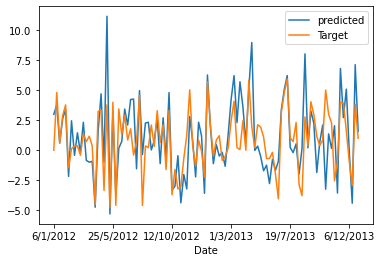

In [22]:
pd.Series(results['portfolio_returns_pred']).plot(label='predicted', legend = True)
#pd.Series(results['y_train']).plot(label='original', legend = True)
pd.Series(results['y_ammended']).plot(label='Target', legend = True)

<AxesSubplot:xlabel='Date'>

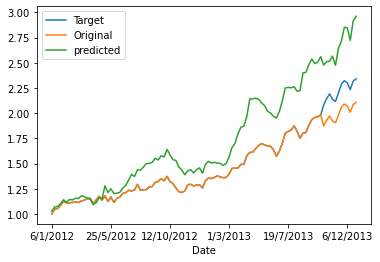

In [23]:
#(pd.Series(results['portfolio_returns_pred']) + 1).cumprod().plot(label='predicted', legend = True)
(pd.Series(results['y_ammended'] / 100) + 1).cumprod().plot(label='Target', legend = True)
(pd.Series(results['y_train'] / 100) + 1).cumprod().plot(label='Original', legend = True)
(pd.Series(np.divide(results['portfolio_returns_pred'],100)) + 1).cumprod().plot(label='predicted', legend = True)

<AxesSubplot:xlabel='Date'>

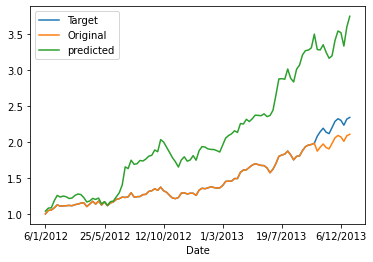

In [27]:
#(pd.Series(results['portfolio_returns_pred']) + 1).cumprod().plot(label='predicted', legend = True)
(pd.Series(results['y_ammended'] / 100) + 1).cumprod().plot(label='Target', legend = True)
(pd.Series(results['y_train'] / 100) + 1).cumprod().plot(label='Original', legend = True)
(pd.Series(np.divide(results['portfolio_returns_pred'],100)) + 1).cumprod().plot(label='predicted', legend = True)

In [78]:
np.divide(results['portfolio_returns_pred'],100)

array([ 3.46445069e-02,  2.86618099e-02,  1.17988614e-02,  7.68659711e-02,
        5.54232225e-02, -1.51829282e-02, -2.82211252e-03,  5.47767035e-04,
       -4.04642988e-03, -6.85918517e-03,  2.41521522e-02,  1.40479123e-02,
       -1.80967932e-03, -3.09049804e-02, -4.81254309e-02,  9.59616620e-03,
        2.26215702e-02, -1.80914328e-02,  3.58292535e-02, -6.79167286e-02,
        2.51868982e-02, -4.39156145e-02,  3.69810238e-02,  1.28626283e-02,
        4.07785885e-02,  2.83755381e-02,  5.30023724e-02,  2.01235577e-01,
        6.78936020e-03,  7.63602704e-02, -2.40700766e-02, -5.99366431e-05,
        2.57905908e-02,  3.44640482e-03,  1.93886831e-02,  2.51910333e-02,
        1.26555394e-02,  3.68312597e-02, -1.96952373e-02,  9.03041288e-02,
       -2.21363287e-02, -3.05698588e-02, -3.19011696e-02, -3.19819376e-02,
       -1.48864649e-02, -3.51425931e-02,  5.26442751e-02,  1.71999950e-02,
       -3.80523428e-02,  1.01961996e-02,  2.43034363e-02, -3.20565104e-02,
        6.25988021e-02,  

In [240]:
filtered_linear_factors[14]['weights']

[0.045593104637516854,
 0.09285418852853493,
 0.0893984998289165,
 0.06328026501871686,
 0.09568369882598678,
 0.05491542363013558,
 0.048321220810894475,
 0.09463250559848689,
 0.047105055039645204,
 0.053406816112134554,
 0.09294549836844308,
 0.031797478720639594,
 0.05718321802412893,
 0.07401305620512966,
 0.05886997065069016]

In [242]:
results['weights'] # puta softmax!!! no está hacianedo lo que quiero!

[0.07133198,
 0.055900585,
 0.05987702,
 0.06958639,
 0.05064902,
 0.07028502,
 0.0743759,
 0.055259615,
 0.07155364,
 0.07840089,
 0.051171493,
 0.08129599,
 0.06723477,
 0.06418966,
 0.078888066]

### deflated sharpe value
https://quantdare.com/deflated-sharpe-ratio-how-to-avoid-been-fooled-by-randomness/

As the mean is zero, there is no significant difference between the original return given by the risk factor from the eigenportfolio, which means the initial hyphotesis that non-lineraities seeked by a defined target are not found or present.

Next ideas: is go from step 1 of deepportfolios to harness least-communal stocks for the specific target!

is is random!

5/5 [==============================] - 0s 910us/step


<AxesSubplot:xlabel='Unnamed: 0'>

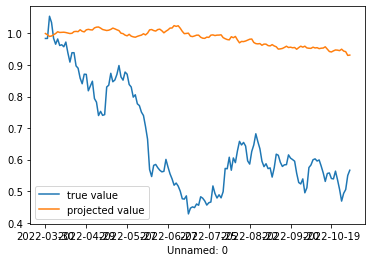

In [310]:
reconstruction = model.predict(df_returns_train)


index = 45

returns_ref = df_returns_train.iloc[:,index]
lp_ref =  pd.Series(((returns_ref + 1).cumprod()))

returns_rec = pd.Series(reconstruction[:,index])
lp_rec =  pd.Series(((returns_rec + 1).cumprod()))

lp_ref.plot(label = 'true value', legend=True)
lp_rec.plot(label = 'projected value', legend=True)

#print(np.linalg.norm((df_returns_train.iloc[:,index] - reconstruction[:,index])) )
